In [1]:
# Importieren von Bibliotheken
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import numpy as np
from matplotlib import pyplot as plt

In [2]:
########################################### Funktionen ######################################################################################

def kinetic (circuit, dt, dx, m):       # Gates zur Simulation der Zeitentwicklung durch H_0
    n = circuit.num_qubits
    N = 2**n
    dp = 2*np.pi/N/dx

    a = -dt/2*dp**2/m
    b = -np.pi/dp/n/dx

    for i in range(n):
        circuit.p(a*2*n*b*2**i, i)
        circuit.p(a*4**i, i)
        for j in range(i+1,n):
            circuit.cp(2*a*2**(i+j),j,i)


    return circuit


def timeEv (circuit, q, dt, dx, m, iterations):     # Zeitentwicklung
    n = circuit.num_qubits 
    for i in range(iterations):
        circuit.append(QFT(n), q[:])
        kinetic(circuit=circuit, dt=dt, dx=dx, m=m)
        circuit.append(QFT(n, inverse=True), q[:])

    return circuit

C:\Users\Tasnim\Documents\Uni\Physik\Sem.6\Bachelorarbeit\env\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


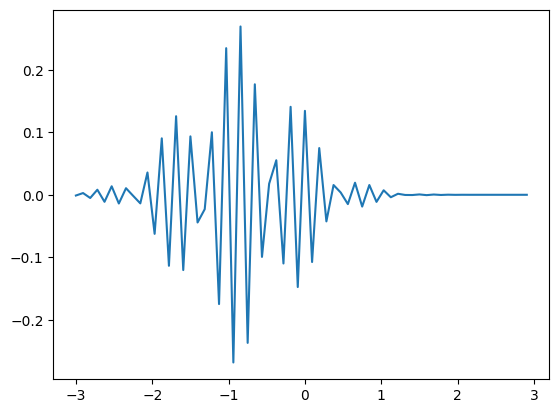

In [3]:
########################################### Startparameter ########################################################################################

n = 6   # Anzahl Qubits
N = 2**n    # Anzahl Gitterpunkte

dt = 0.001
m = 0.1

# Ortsraumgitter
d = 3
dx = 2*d/N
""" dx= 1
d = N*dx/2 """
x = np.arange(-d, d, dx)


# Gaußsches Wellenpaket als Anfangszustand
mu=x[23]
sigma = 0.5
psi= np.sqrt(1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(0.5*(x-mu)**2)/(sigma**2))) * np.exp(-30j*x)
#psi= np.sqrt(1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(0.5*(x-mu)**2)/(sigma**2)))
psi/= np.sqrt(np.sum(np.abs(psi**2)))


plt.plot(x, psi)

In [5]:
########################################### Simulation Zustandsvektor ##########################################################################

q = QuantumRegister(n)      # Erzeugen eines Quantenregisters ohne ancilla-Qubit
circuit = QuantumCircuit(q) # Erstellen eiens circuits


#Initialisierung des Anfangszustandes
circuit.initialize(psi,q[:])

# Festlegen des Simulators, hier Zustandsvektor-Simulator
simulator = Aer.get_backend('statevector_simulator')

# Array, in dem die Zeitentwicklung der Wahrscheinlichkeitsdichte gespeichert wird
evolution = []

# Speichern des Anfangszustandsvektors 
statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
prob = statevector.probabilities()
evolution.append(prob)

# Simulation der Zustandsvektoren der einzelnen Zeitschritte 
it = 15
rg = 6      # Anzahl der Zeitzwischenschritte die geplottet werden sollen

for i in range(rg):
    timeEv(circuit, q, dt, dx, m, iterations=it)
    prob = []
    statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
    print(str(i) + ':' + str(statevector.is_valid()))        # Ausgabe der Normierungsüberprüfung um Fortschritt der Simulation sichtbar zu machen
    prob = statevector.probabilities()
    evolution.append(prob)

0:True
1:True
2:True
3:True
4:True
5:True


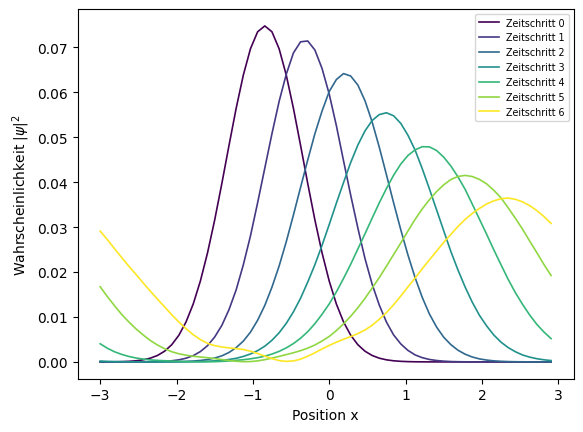

In [9]:
########################################### Plots ################################################################################################

peak_position = []      # Array, in dem die Positionen der Gauß-Kurven gespeichert werden

colors = plt.cm.viridis(np.linspace(0,1,rg+1))

for i in range(len(evolution)):
    plt.plot(x, evolution[i], color=colors[i], linewidth=1.2, label='Zeitschritt ' + str(i))
    peak_position.append(x[np.argmax(evolution[i])])

plt.xlabel('Position x')
plt.ylabel(r'Wahrscheinlichkeit $|\psi|^2$')
plt.legend(loc='upper right', fontsize='x-small')

#plt.savefig('timeev_direkte_berechnung.jpg', bbox_inches='tight', dpi=300)

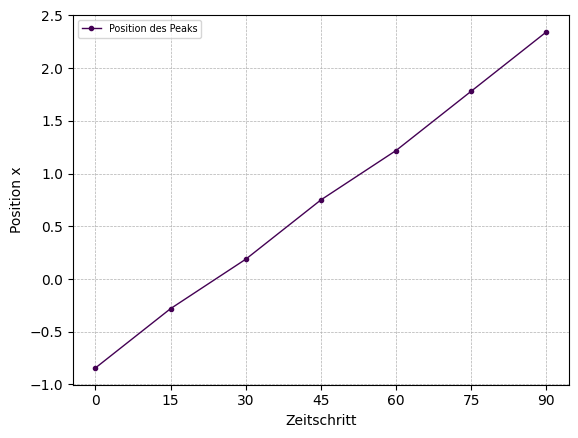

In [10]:
########################################### Peak Positionen ######################################################################################

tsteps = [i*it for i in range(rg+1)]
plt.plot(tsteps, peak_position, marker='.', color=plt.cm.viridis(0), linewidth='1', label='Position des Peaks')
plt.xlabel('Zeitschritt')
plt.ylabel('Position x')
plt.xticks(tsteps, tsteps)
plt.legend(loc='upper left', fontsize='x-small')
plt.grid(linestyle='--', linewidth=0.5)

#plt.savefig('timeev_gauss_peakposition_direkte_berechnung.jpg', bbox_inches='tight', dpi=300)